# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

In [34]:
import tensorflow as tf
from tensorflow import Variable
import functools
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split
import cv2
import scipy.ndimage as ndi

C:\Anaconda2\envs\CarND-Traffic-Sign-Classifier-Project\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


---
## Step 0: Load The Data

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.
import numpy as np
# TODO: Number of training examples
n_train = X_train.shape[0]

# TODO: Number of testing examples.
n_test = X_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train.shape[1:4]

# TODO: How many unique classes/labels there are in the dataset.
n_classes = np.unique(y_test).shape[0]

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

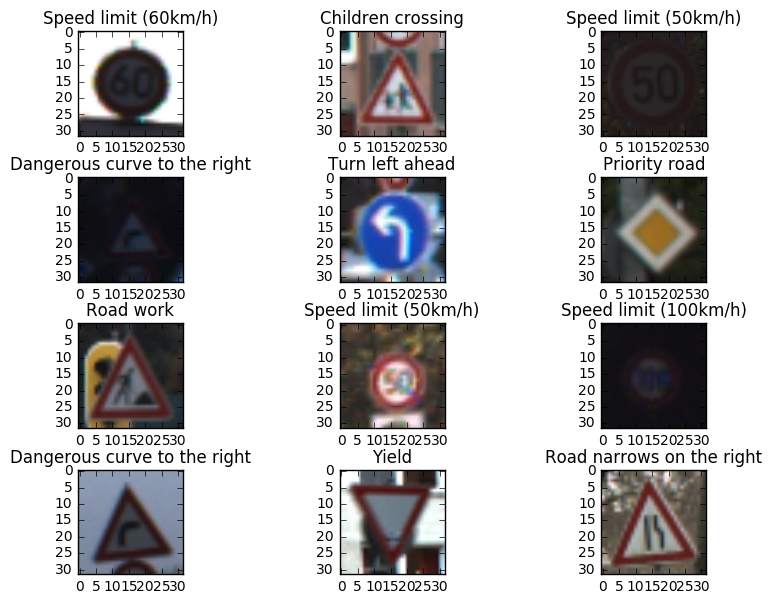

In [5]:
import pandas as pd

df = pd.read_csv("signnames.csv")
label_descriptions = dict()
for item in df.iterrows():
    r = item[1]
    ClassId = r['ClassId']
    SignName = r['SignName']
    
    label_descriptions[ClassId] = SignName

    
n_rows = 4
n_cols = 3
n_samples = n_rows*n_cols
sample = np.random.randint(0, n_train, n_samples)
sample_images = X_train[sample]
sample_labels = [label_descriptions[s] for s in  y_train[sample]]

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(2*n_rows, 2*n_cols))
axes = axes.ravel()
fig.tight_layout()
for axis, image, label in zip(axes, sample_images, sample_labels):
    axis.imshow(image)
    axis.set_title(label)

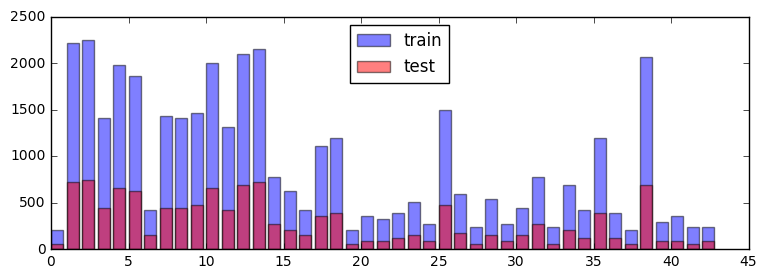

In [6]:
def draw_hist(bins_train,bins_test):
    plt.figure(figsize=(9, 3))
    plt.bar(range(n_classes), bins_train, label="train", color="b", alpha=0.5)
    plt.bar(range(n_classes), bins_test, label="test", color="r", alpha=0.5)
    plt.legend(loc="best")

bins_train = np.bincount(y_train)
bins_test = np.bincount(y_test)
draw_hist(bins_train,bins_test)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

# Generate Data

As it is very much certain that while capturing the images , the orientations will be different. Thus, in order to make model invariant of orientation of traffic signals in the frame we are creating some more extra examples by rotating and shifting images.

In [83]:
def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x], [0, 1, o_y], [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x], [0, 1, -o_y], [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

def apply_transform(x, transform_matrix, channel_index=2, fill_mode='nearest', cval=0.):
    x = np.rollaxis(x, channel_index, 0)
    final_affine_matrix = transform_matrix[:2, :2]
    final_offset = transform_matrix[:2, 2]
    channel_images = [ndi.interpolation.affine_transform(x_channel, final_affine_matrix,
                      final_offset, order=0, mode=fill_mode, cval=cval) for x_channel in x]
    x = np.stack(channel_images, axis=0)
    x = np.rollaxis(x, 0, channel_index+1)
    return x

def random_rotation(img, degree=30):
    theta = np.pi / 180 * np.random.uniform(-degree, degree)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])
    h, w = img.shape[0], img.shape[1]
    transform_matrix = transform_matrix_offset_center(rotation_matrix, h, w)
    x = apply_transform(img, transform_matrix, channel_index=2)
    return x

def random_shift(img, shiftw=0.15, shifth=0.15):
    h, w = img.shape[0], img.shape[1]
    tx = np.random.uniform(-shifth, shifth) * h
    ty = np.random.uniform(-shiftw, shiftw) * w
    translation_matrix = np.array([[1, 0, tx],
                                   [0, 1, ty],
                                   [0, 0, 1]])
    transform_matrix = translation_matrix  # no need to do offset
    x = apply_transform(img, transform_matrix, 2)
    return x

In [114]:
train_features2 = np.copy(X_train)
y_train2 = np.copy(y_train)
print("Before Transformation")
print("Train Feature:", train_features2.shape)
print("Feature Label:", y_train2.shape)

count_train = []
for i in range(n_classes):
    count = len(y_train[y_train==i])
    count_train.append(count)

for i in range(n_classes):   
    print("Generating Sample for label {0}".format(i))
    if count_train[i] < 500:
        for count in range(num - count_train[i]):
            rand = int(100*random.random())
            rot = random_rotation(X_train[np.argwhere(y_train==cls)[rand]][0])
            shift = random_rotation(X_train[np.argwhere(y_train==cls)[rand]][0])
            train_features2 = np.append(train_features2, [rot, shift], axis=0)
            y_train2 = np.append(y_train2, [cls, cls], axis=0)

print("++++++++++++++++++++++++++++++++++++++++++++++++++")
print("After Transformation")
print("Train Feature:", train_features2.shape)
print("Feature Label:", y_train2.shape)

Before Transformation
Train Feature: (39209, 32, 32, 3)
Feature Label: (39209,)
Generating Sample for label 0
Generating Sample for label 1
Generating Sample for label 2
Generating Sample for label 3
Generating Sample for label 4
Generating Sample for label 5
Generating Sample for label 6
Generating Sample for label 7
Generating Sample for label 8
Generating Sample for label 9
Generating Sample for label 10
Generating Sample for label 11
Generating Sample for label 12
Generating Sample for label 13
Generating Sample for label 14
Generating Sample for label 15
Generating Sample for label 16
Generating Sample for label 17
Generating Sample for label 18
Generating Sample for label 19
Generating Sample for label 20
Generating Sample for label 21
Generating Sample for label 22
Generating Sample for label 23
Generating Sample for label 24
Generating Sample for label 25
Generating Sample for label 26
Generating Sample for label 27
Generating Sample for label 28
Generating Sample for label 29


# Train , Test, Valid Split

In [121]:
X_train, X_valid, y_train, y_valid = train_test_split(train_features2, y_train2, test_size=0.05)
print("Train Feature:", X_train.shape)
print("Train Label:", y_train.shape)
print("Validation Feature:", X_valid.shape)
print("Validation Label:", y_valid.shape)
print("Test Feature:", X_test.shape)
print("Test Label:", y_test.shape)

Train Feature: (43955, 32, 32, 3)
Train Label: (43955,)
Validation Feature: (2314, 32, 32, 3)
Validation Label: (2314,)
Test Feature: (12630, 32, 32, 3)
Test Label: (12630,)


In [122]:
import os
pickle_file = 'new_train.p'
if not os.path.isfile(pickle_file):
    try:
        with open(pickle_file, 'wb') as pfile:
            pickle.dump({'train_dataset': X_train,'train_labels': y_train,
                    'valid_dataset': X_valid,'valid_labels': y_valid,
                    'test_dataset': X_test,'test_labels': y_test,},pfile, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', pickle_file, ':', e)
        raise
print('Data Saved')

Data Saved


# Load Data

In [3]:
import pickle
pickle_file = 'new_train.p'
with open(pickle_file, 'rb') as f:
    pickle_data = pickle.load(f)
    X_train = pickle_data['train_dataset']
    y_train = pickle_data['train_labels']
    X_valid = pickle_data['valid_dataset']
    y_valid = pickle_data['valid_labels']
    X_test = pickle_data['test_dataset']
    y_test = pickle_data['test_labels']
    del pickle_data 

print("Train Feature:", X_train.shape)
print("Train Label:", y_train.shape)
print("Validation Feature:", X_valid.shape)
print("Validation Label:", y_valid.shape)
print("Test Feature:", X_test.shape)
print("Test Label:", y_test.shape)

Train Feature: (43955, 32, 32, 3)
Train Label: (43955,)
Validation Feature: (2314, 32, 32, 3)
Validation Label: (2314,)
Test Feature: (12630, 32, 32, 3)
Test Label: (12630,)


# Process Data

* RGB to YUV : This allows reduced bandwidth for chrominance components to take in account
    - Y <- Stands for the luma component that defines brightness 
    - U and V are the chrominance (color) components
* Normalize the image by changing the image pixel range between 0 - 255 only, this is make all images in same pixel range that helps gradient descent to converge faster and also when applying any mathematical transformation the feature range should be same in order to restrict the range of the function and thus to make useful inference.

In [5]:
import numpy as np
class PreProcess():
    def to_grayscale(self,images):
        return np.array([cv2.cvtColor(img, cv2.COLOR_RGB2YUV)[:,:,0] for img in images])

    def to_normalize(self,images):
        return images / 255.

    def to_expanddim(self,images):
        return np.expand_dims(images, axis=3)

    def to_float32(self,images):
        return images.astype(np.float32)

    def run(self,images):
        gray = self.to_grayscale(images)
        norm = self.to_normalize(gray)
        expand = self.to_expanddim(norm)

        return self.to_float32(expand)
    
preProcessor = PreProcess()

X_train = preProcessor.run(X_train)
X_test = preProcessor.run(X_test) 
X_valid = preProcessor.run(X_valid) 

In [6]:
X_train.shape,X_valid.shape,X_test.shape

((43955, 32, 32, 1), (2314, 32, 32, 1), (12630, 32, 32, 1))

14


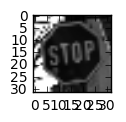

In [7]:
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

index = random.randint(0, len(X_train))
image = X_train[index].squeeze()

plt.figure(figsize=(1,1))
plt.imshow(image, cmap="gray")
print(y_train[index])

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** 
1. RGB to GrayScale conversion
2. Histogram Equalization 
3. Normalize the pixels using Min Max Scaling which brings into [0,1]
4. One Hot Encoding for output

# LeNet Architecture

In [59]:
import tensorflow as tf

EPOCHS = 25
BATCH_SIZE = 128

from tensorflow.contrib.layers import flatten
from sklearn.utils import shuffle

def LeNet(x):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Convolutional. Input = 32x32x1. Output = 28x28x6. 
    # 6 Filters: (5x5x1). 
    # A stride of 1 for both the height and width (S)
    # Valid padding of size 1 (P)
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Convolutional. Output = 10x10x16.
    # 16 Filters: (5x5x6). 
    # A stride of 1 for both the height and width (S)
    # Valid padding of size 1 (P)
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)

    # Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits

# Training

In [60]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

learning_rate = 0.001
logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
training_operation = optimizer.minimize(loss_operation)
prediction = tf.nn.softmax(logits)
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [61]:
%%time 
X_train, y_train = shuffle(X_train, y_train)

with tf.Session(config=tf.ConfigProto(log_device_placement=True)) as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet_with_new_data.ckpt')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.806

EPOCH 2 ...
Validation Accuracy = 0.887

EPOCH 3 ...
Validation Accuracy = 0.941

EPOCH 4 ...
Validation Accuracy = 0.948

EPOCH 5 ...
Validation Accuracy = 0.963

EPOCH 6 ...
Validation Accuracy = 0.965

EPOCH 7 ...
Validation Accuracy = 0.971

EPOCH 8 ...
Validation Accuracy = 0.969

EPOCH 9 ...
Validation Accuracy = 0.977

EPOCH 10 ...
Validation Accuracy = 0.982

EPOCH 11 ...
Validation Accuracy = 0.981

EPOCH 12 ...
Validation Accuracy = 0.980

EPOCH 13 ...
Validation Accuracy = 0.977

EPOCH 14 ...
Validation Accuracy = 0.976

EPOCH 15 ...
Validation Accuracy = 0.983

EPOCH 16 ...
Validation Accuracy = 0.977

EPOCH 17 ...
Validation Accuracy = 0.982

EPOCH 18 ...
Validation Accuracy = 0.982

EPOCH 19 ...
Validation Accuracy = 0.985

EPOCH 20 ...
Validation Accuracy = 0.982

EPOCH 21 ...
Validation Accuracy = 0.987

EPOCH 22 ...
Validation Accuracy = 0.981

EPOCH 23 ...
Validation Accuracy = 0.990

EPOCH 24 ...
Validation Accura

In [64]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.904


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:**

In addition to the original dataset, the new data is Generated through image augmentation i.e Image rotation & Image shif in order to make the dataset more robust and generalized, thus some shifted images and some rotated images has been generated for each class in the training dataset. Finally in the training set we had 500 images for each class.
Affine Transform has been used for random rotation and for random shift we just translated the image through different axis. But the testing accuracy is somewhat similar in the both cases.

Data has been split into Train, Valid and Test

As test and train was already given thus a validation set has been extracted from the training dataset only.

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**

Lenet Architecture has been used, which was used for MNIST also. While changing the parameters.
The, LeNet Architecture is as follow:

##### Deep Neural Network Architecture

---
- <b><u>Convolution Layer</u></b> :
    * <b>Input</b> = 32x32x1 
    * 6 Filters = 5x5x1
    * Strides = 1x1x1
    * Padding='VALID'
    * <b>Output</b> = 28x28x6
- <b><u>Activation function</u></b> : (ReLU)
- <b><u>Pooling</u></b> :  
    * <b>Input</b> = 28x28x6 
    * Filters = 2x2x1 
    * Strides = 2x2x1
    * <b>Output</b> = 14x14x6 
---
- <b><u>Convolution Layer</u></b> :
    * <b>Input</b> = 14x14x16
    * 16 Filters = 5x5x6
    * Strides = 1x1x1
    * Padding='VALID'
    * <b>Output</b> = 10x10x16 
- <b><u>Activation function</u></b> : (ReLU)
- <b><u>Pooling</u></b> :
    * <b>Input</b> = 10x10x16 
    * Filters = 2x2x1
    * Strides = 2x2x1
    * <b>Output</b> = 5x5x16 
---

- <b><u>Flatten the output shape of the final pooling layer</u></b> : 
    * Input = 5x5x16
    * Output = 400

---
- <b><u>Fully Connected layer</u></b> : 
    * Input = 400
    * Output = 120
- <b><u>Activation function</u></b> : (ReLU)
------
- <b><u>Fully Connected layer</u></b> :
    * Input = 120
    * Output = 84
- <b><u>Activation function</u></b> -> (ReLU)
---
- <b><u>Fully Connected layer</u></b> :
    * Input = 84
    * Output = 43

In [21]:
### Train your model here.
### Feel free to use as many code cells as needed.

Done in the uper cells.

### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**

Batch Size of 128 and in 25 epchos using the AdamOptimizer with the loss optimizer is being used to train the model.
Learning Rate: 0.001
Mean and Standard Deviation in the LeNet to 0 and 0.1 respectively.
Thus, we get the 90% of testing accuracy on the testing dataset being provided.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
1. Applied without Preprocessing
2. Tried without generating the augmented dataset
3. Changing the Fully Connected Layers from 2 to 1 and 1 to 2 in the CNN
4. Tried the VALID and SAME padding both
5. After trying and testing all the approaches the final architecture has been chosen
6. Gradient Descent and Adam Optimizers has been tested out too

Before choosing the Lenet, the following architecture has been chosen. That gives testing accuracy of around 84%
    - Input
    - Convolutional Layer with depth 32
    - ReLU layer
    - Max Pool 2 x 2
    - Dense Layer (input size: 8 * 8 * 32, output size: 128)
    - Dropout (Probability 0.5)
    - Dense Layer (input size: 128, output size: 43)
Then after testing out the LeNet, which is a proved architecture the accuracy seems to increase.

Though, I will also try to test out the VggNet Architecture and  GooLeNet Architecture. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [18]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
import os
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
from tensorflow import Variable
import matplotlib.pyplot as plt
%matplotlib inline

new_data = 'test_data'
test_images_x = []
test_images_y = []
for l in os.listdir(new_data):
    label,ext = l.split(".")
    if ext=='jpg' or ext=='JPG':
        img = cv2.imread("test_data/"+l)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (32, 32))
        test_images_x.append(img)
        test_images_y.append(int(label))

np.shape(test_images_x)

(8, 32, 32, 3)

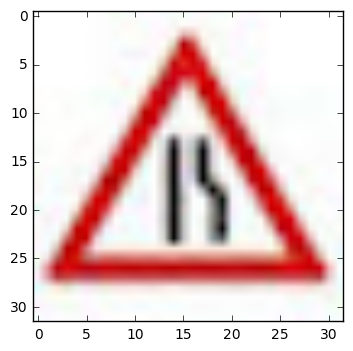

In [3]:
plt.imshow(test_images_x[1])

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
Images has been taken with very small size and very big sizes.
Also the images with a background has been taken in account too. Rather than just the focused traffic signal.

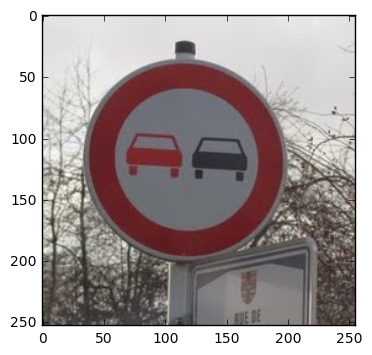

In [4]:
plt.imshow(test_images_x[2])

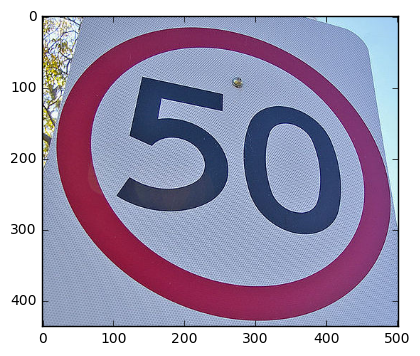

In [5]:
plt.imshow(test_images_x[4])

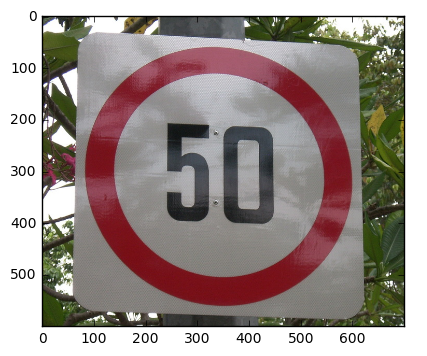

In [6]:
plt.imshow(test_images_x[5])

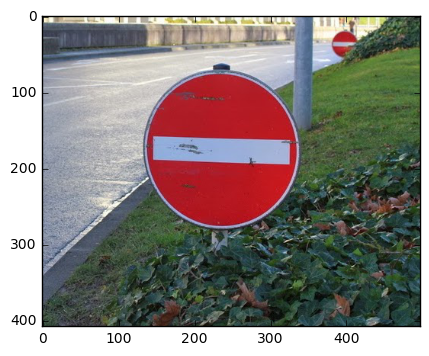

In [7]:
plt.imshow(test_images_x[6])

In [19]:
preProcessor = PreProcess()
test_images_x = preProcessor.run(test_images_x)
test_images_y = np.array(test_images_y)
test_images_x.shape,test_images_y.shape

((8, 32, 32, 1), (8,))

In [20]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(test_images_x, test_images_y)
    tf.nn.top_k(test_images_x, 3)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.375


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**

Unfortunately, the accuracy seems to be low around 37.5% for 8 test images.

In [ ]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [48]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    a = sess.run(prediction, feed_dict={x: test_images_x})
    top_3 = sess.run(tf.nn.top_k(a,3))

In [47]:
test_images_y

array([ 0, 24,  3, 14,  2,  4,  9,  5])

In [62]:
count = 0
for i,j in zip(top_3.indices,test_images_y):
    print(i,j)
    if j in i:
        count+=1  
        
print("Images occuring in top 3 : {0} ".format(count))

[ 3 29 35] 0
[24 31 21] 24
[37  4 14] 3
[14 25 33] 14
[ 1 40 11] 2
[ 9 35 23] 4
[12 40  9] 9
[27 23 28] 5
Images occuring in top 3 : 3 


**Answer:**

Only 3 images amongst the 8 are in the top 3 softmax probablities

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.